# Social Media Sentiment Analysis

__BACKGROUND__

A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist for sentiment analysis, however, they need help with under-resourced languages.

__GOAL__

Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently labeled. Please describe the business outcomes in your work sample including how data limitations impact your results and how these limitations could be addressed in a larger project.

__DATA__ 

Link to data: http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set

## Data Loading and Inspection

We first explore the data. We have been warned that the training data "includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently labeled" and we want to understand the implications of these challenges. 

In [3]:
# Import the necessary libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import sklearn
import random as random
random.seed(5) 
import os
import keras as k
import csv

Using TensorFlow backend.


In [5]:
data = pd.read_csv('RomanUrduDataSet.csv',sep=',',names=['text','sentiment'],index_col=False, 
                  quotechar='"',na_values='NULL')

In [6]:
data.shape

(20229, 2)

In [7]:
data.describe()

,text,sentiment
count,20228,20229
unique,19664,4
top,Good,Neutral
freq,23,8929


In [8]:
data['sentiment'].value_counts()

Neutral     8929
Positive    6013
Negative    5286
Neative        1
Name: sentiment, dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 2 columns):
text         20228 non-null object
sentiment    20229 non-null object
dtypes: object(2)
memory usage: 316.2+ KB


In [18]:
print(data.loc[4786,'text'])

mere sheer🦁 mere cheety🐯 😘😘😘


In [10]:
data.sample(60)

,text,sentiment
4360,Hahahah sanam yad ha?,Neutral
7269,Wo gaeyki kea mal ko bandage bana dete hain,Neutral
6141,Promotion main k creative main,Neutral
11072,Liaquatabad Me Firing 1 Shaks Zakhmi,Negative
13902,Ditto copy hai batay bhi apki trah krta hai,Neutral
12383,Rajesh Khanna apne urooj ke dino mien jab bah...,Negative
8551,Inka aik beata beh tha agar uski pic dekha day...,Neutral
19951,Hamari aadhi se zayada awaam toh andhi hai apn...,Negative
4786,mere sheer🦁 mere cheety🐯 😘😘😘,Neutral
3737,Tujhe pata ha me q Hans Raha ho ye jis k bat K...,Positive


In [19]:
data['text'] = data['text'].apply(str)
data['sentiment'] = data['sentiment'].apply(str)

In [20]:
data['textLength'] = data['text'].apply(len)
data['textWordCount'] = data['text'].apply(lambda x: len(x.split(' ')))

In [21]:
data[data['textLength']==0]

,text,sentiment,textLength,textWordCount


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 4 columns):
text             20229 non-null object
sentiment        20229 non-null object
textLength       20229 non-null int64
textWordCount    20229 non-null int64
dtypes: int64(2), object(2)
memory usage: 632.2+ KB


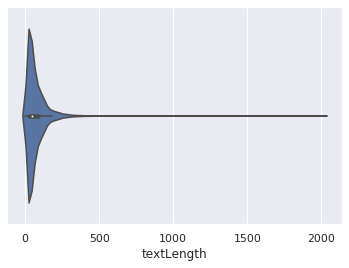

In [23]:
sns.violinplot(data['textLength'])

In [24]:
sum(data['textLength'] > 500)

46

In [25]:
i = 0
for line in data.loc[data['textLength'] > 500,'text']:
    print(line)
    i+=1
    if i >=10:
        break

Gumshoda aur agwa shoda ashkhas ki bazyabi key leye Beuro aur insedad dehsht gerdi key lea aik comition yeh trust aik gair serkari gair seasi aur gair munfiet andoz insani haqooq ki die tanzem hay aur is ski rejgtration Amrica mein bhi ho chuki hay inn ki mosalsal aur bea louse koshishon sey ab tek lakhon sey zaida aeyse quadi reha ho chukey hain jog air qanooni tour par Pakistan aur barony mumalik mein quaid rahey inn mein sey baz jailon mein hi paida huay they aur chalees chalees sal bea qasoor aur bea gunah sakht moshaqqat ki zindagi mahaz laquniat ki waja sey guzar rahey thay neaz bees hazar sey zaidah gumshudah aur agwa shudah bachchon aur bachion ko baziab karaya ja chukka hay halankey iss hawaley sey unhain khasi tanqeed ka nishana banna para.
Insani haqooq key leyeh Ansar Burney ki khidmat key aeteraf mein hukumat Pakistan ki taraf sey unhain sitara e imtaiaz sey nawaza gea aur kai bainul aqwami aizazat bhi unkey hissay mein aeay hain taham jaisa key pehley ziker hua unhain kai

## ToDo:

treat emojis like words

extract punctuation

### Notes:

__English Usage__:

there is light english usage and some posts are all english
list examples

__Emoji's__:

use of emoji's

__Length__:

long tail of very long posts. look at how they might affect any embedding creation

__Capitalization__:

i will make assumption that it's ok to lower case everything


## Model 1: Naive 

- get top words
- derive P(sentiment | word)

## Model 2: Random Forest

## Model 3: Text Embedding and LSTM

In [231]:
import numpy as np
np.random.seed(34)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import random
import itertools

### Text embedding using word2vec

__Employ Word2Vec in gensim__

We set _min_count_ (minimum number of word occurences) of 2 as the number of distinct words is small.

We scan through setting _size_ (dimension of embedding space) at 20, 50, and 100.

We scan through _window_ (words on either side to be considered for content-target pairs) at 2, 5, 7.

In [31]:
# Import relevant packages
import nltk
nltk.download('punkt')
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to /home/cfrailey/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

To 

In [233]:
# Parse all sentences and then all words within sentences to end up with a list of lists
sentences = []
for line in data.iloc[:,0]:
    sentences += nltk.sent_tokenize(line.lower())

words_in_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

# Create Embeddings for sizes of 20, 50, 100 and windows of 2,5,7
sizes = [10,50,100]
windows = [2,5,7]

word2vec = {(s,w): Word2Vec(words_in_sentences, min_count = 2, size = s, seed = 28, window = w) 
            for (s,w) in itertools.product(sizes,windows)}

In [218]:
data['words'] = data['text'].apply(lambda x: nltk.word_tokenize(x.lower()))

In [219]:
data['centerOfMass'] = data['words'].apply(lambda x: 
                                           ((0 + sum([word2vec.wv[i] for i in x if i in word2vec.wv.vocab]))/
                                            sum([1 for i in x if i in word2vec.wv.vocab])) 
                                           if sum([1 for i in x if i in word2vec.wv.vocab]) > 0 
                                            else 0
                                          )

__Find Average of Embedding__

In [ ]:
def 

In [220]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [221]:
def sentence_to_avg(sentence, vocab):
    w = nltk.word_tokenize(sentence.lower())
    if sum([1 for i in w if i in vocab]) > 0:
        return ((np.zeros(40) + sum([word2vec.wv[i] for i in w if i in vocab]))/
        sum([1 for i in w if i in vocab]))
    else:
        return np.zeros(40)


In [222]:
def categorify(x):
    if x == 'Neutral':
        return [0,1,0]
    elif x == 'Positive':
        return [0,0,1]
    else:
        return [1,0,0]

def convert_to_one_hot(x):
    return np.array([categorify(i) for i in x])

In [223]:
def predict(X,Y,W,b,word_to_vec_map):
    B = np.array([sentence_to_avg(X[i],word_to_vec_map) for i in range(X.shape[0])]).T
    print(b)
    A = np.dot(W,B)
    Z = A + b.reshape(b.shape[0],1)
    return A.argmax(axis = 0)

In [224]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 3                                 # number of classes  
    n_h = 40                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
            ### START CODE HERE ### (≈ 4 lines of code)
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i],word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -1*np.sum(Y_oh[i]*np.log(a))
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [225]:
p,w,b = model(np.array(data['text']), np.array(['sentiment']), word2vec.wv, learning_rate = 0.1, num_iterations = 400)

Epoch: 0 --- cost = 0.7733479395376864
[ 0.05385345 -0.0064784  -0.04737505]
Epoch: 100 --- cost = 0.0017971087361940503
[ 0.1142055  -0.03161191 -0.08259359]
Epoch: 200 --- cost = 0.0009179966365878406
[ 0.1267576  -0.03736396 -0.08939364]
Epoch: 300 --- cost = 0.0006167516276630561
[ 0.13421461 -0.04083189 -0.09338272]


In [227]:
np.where(p == 1)

(array([  400,   408,  4729,  4908,  4912,  4917,  4941,  4942,  4949,
         4952,  5181,  7758,  7799,  7801,  7876,  8019,  8078,  8106,
         8161,  8171,  8225,  8247,  8251,  8276,  8336,  8359,  8540,
         8667,  8685,  8695,  8705,  8706,  8723,  8817,  8832,  8847,
         8925,  8935,  8960,  8969,  8971,  9016,  9046,  9124,  9129,
         9184,  9246,  9299,  9497,  9592,  9623,  9784,  9798,  9818,
         9821,  9838,  9847,  9940, 10015, 12594]),)

In [229]:
data[data['sentiment']=='Neutral']

,text,sentiment,textLength,textWordCount,words,centerOfMass
3762,hakeqat hy,Neutral,10,2,"[hakeqat, hy]","[0.75251245, 0.0776818, 0.095808074, -1.159567..."
3763,Aor aisy bahut km hain ryt,Neutral,26,6,"[aor, aisy, bahut, km, hain, ryt]","[0.38251778, 0.006456249, 0.051981937, -0.6951..."
3764,jee ye to he,Neutral,12,4,"[jee, ye, to, he]","[1.046562, 0.07061133, 0.2703947, -1.600706, 0..."
3765,Hmm jysa kro gy wysa bhru gy,Neutral,28,7,"[hmm, jysa, kro, gy, wysa, bhru, gy]","[0.2534079, 0.009493693, 0.03590196, -0.555417..."
3766,Ye kia hoa raha hain Pakistan main,Neutral,34,7,"[ye, kia, hoa, raha, hain, pakistan, main]","[1.1885339, 0.00704305, 0.18625316, -1.8513792..."
3767,Ghreeb k ghr subh kia pkky ga??,Neutral,31,7,"[ghreeb, k, ghr, subh, kia, pkky, ga, ?, ?]","[0.8230414, -0.15290363, -0.13649154, -1.31429..."
3768,Ye kia bat hoe,Neutral,14,4,"[ye, kia, bat, hoe]","[1.0048538, 0.014511136, 0.16833408, -1.407355..."
3769,Ri8 but naseeb ki bat h 😔,Neutral,25,7,"[ri8, but, naseeb, ki, bat, h, 😔]","[0.6268309, 0.05406679, 0.11216164, -1.2520534..."
3770,Ya post sabka laiy,Neutral,18,4,"[ya, post, sabka, laiy]","[0.43568188, 0.017439466, 0.07343759, -0.81733..."
3771,Khabi khabi mera dill mn keal ata ha demaz k h...,Neutral,90,22,"[khabi, khabi, mera, dill, mn, keal, ata, ha, ...","[0.6171575, 0.04382, 0.13649113, -1.0979215, 0..."
